# Time variability

In this tutorial, we will cover how to instatiate a time-variable `StarryProcess`, useful for modeling stars with spots that evolve over time. We will show how to sample from the process and use it to do basic inference.

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Disable annoying font warnings
matplotlib.font_manager._log.setLevel(50)

# Disable theano deprecation warnings
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="theano")

# Style
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.size"] = 14
plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
try:
    plt.rcParams["mathtext.fallback"] = "cm"
except KeyError:
    plt.rcParams["mathtext.fallback_to_cm"] = True
plt.rcParams["mathtext.fallback_to_cm"] = True

# Short arrays when printing
np.set_printoptions(threshold=0)

In [4]:
del matplotlib
del plt
del warnings

## Setup

In [5]:
from starry_process import StarryProcess
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import theano
import theano.tensor as tt

To instantiate a time-variable `StarryProcess`, we simply pass a nonzero value for the `tau` parameter:

In [6]:
sp = StarryProcess(tau=25.0)

This is the timescale of the surface evolution in arbitrary units (i.e., this will have the same units as the rotation period and the input time arrays; units of days are the common choice). We can also provide a GP kernel to model the time variability. By default a Matern-3/2 kernel is used, but that can be changed by supplying any of the kernels defined in the `starry_process.temporal` module with the `kernel` keyword. If you wish, you can even provide your own callable tensor-valued function of the form

```python
def kernel(t1, t2, tau):
    (...)
    return K
```

where `t1` and `t2` are the input times (scalars or vectors), `tau` is the timescale, and `K` is a covariance matrix of shape ``(len(t1), len(t2))``. 

Let's stick with the `Matern32` kernel for now, and specify a time array over which we'll evaluate the process:

In [7]:
t = np.linspace(0, 50, 1000)

## Sampling

### Sampling in spherical harmonics

The easiest thing we can do is sample maps. For time-variable processes, we can pass a time `t` argument to `sample_ylm` to get map samples evaluated at different points in time:

In [8]:
y = sp.sample_ylm(t).eval()
y

array([[[ 1.98197188e-06, -3.81494229e-03,  9.46731253e-03, ...,
         -1.61085768e-03, -1.21449760e-03,  2.61072812e-03],
        [ 1.98777184e-06, -3.72789607e-03,  9.40451471e-03, ...,
         -1.60980601e-03, -1.21834164e-03,  2.60772800e-03],
        [ 1.99385008e-06, -3.64801549e-03,  9.33341106e-03, ...,
         -1.60858574e-03, -1.22108089e-03,  2.60411143e-03],
        ...,
        [ 3.97931716e-07,  8.24641009e-03, -2.11995613e-02, ...,
          5.60005485e-04, -1.51144083e-03,  1.51503707e-03],
        [ 3.93531500e-07,  8.23100299e-03, -2.13551280e-02, ...,
          5.49545556e-04, -1.49624831e-03,  1.51438912e-03],
        [ 3.88700381e-07,  8.21886616e-03, -2.15127955e-02, ...,
          5.39429603e-04, -1.48113807e-03,  1.51377760e-03]]])

Note the shape of `y`, which is `(number of samples, number of times, number of ylms)`:

In [9]:
y.shape

(1, 1000, 256)

At every point in time, the spherical harmonic representation of the surface is different. We can visualize this as a movie by simply calling

```python
sp.visualize(y)
```

In [10]:
# We actually tweak the contrast a little,
# and downsample to make this run quicker
sp.visualize(y[:, ::10], vmin=0.6, vmax=1.3)

Computing the corresponding light curve is easy:

In [11]:
flux = sp.flux(y, t).eval()
flux

array([[-0.01631175, -0.01916606, -0.02341942, ...,  0.00161407,
        -0.01026314, -0.02248795]])

where the shape of `flux` is `(number of samples, number of times)`:

In [12]:
flux.shape

(1, 1000)

We could also pass explicit values for the following parameters (otherwise they assume their default values):

In [13]:
from IPython.display import display, Markdown
from starry_process.defaults import defaults

defaults["u"] = defaults["u"][: defaults["udeg"]]
display(
    Markdown(
        """
| attribute | description | default value |
| - | :- | :-:
| `i` | stellar inclination in degrees | `{i}` |
| `p` | stellar rotation period in days | `{p}`|
| `u` | limb darkening coefficient vector | `{u}` |
""".format(
            **defaults
        )
    )
)


| attribute | description | default value |
| - | :- | :-:
| `i` | stellar inclination in degrees | `60.0` |
| `p` | stellar rotation period in days | `1.0`|
| `u` | limb darkening coefficient vector | `[0. 0.]` |


Here's the light curve in parts per thousand:

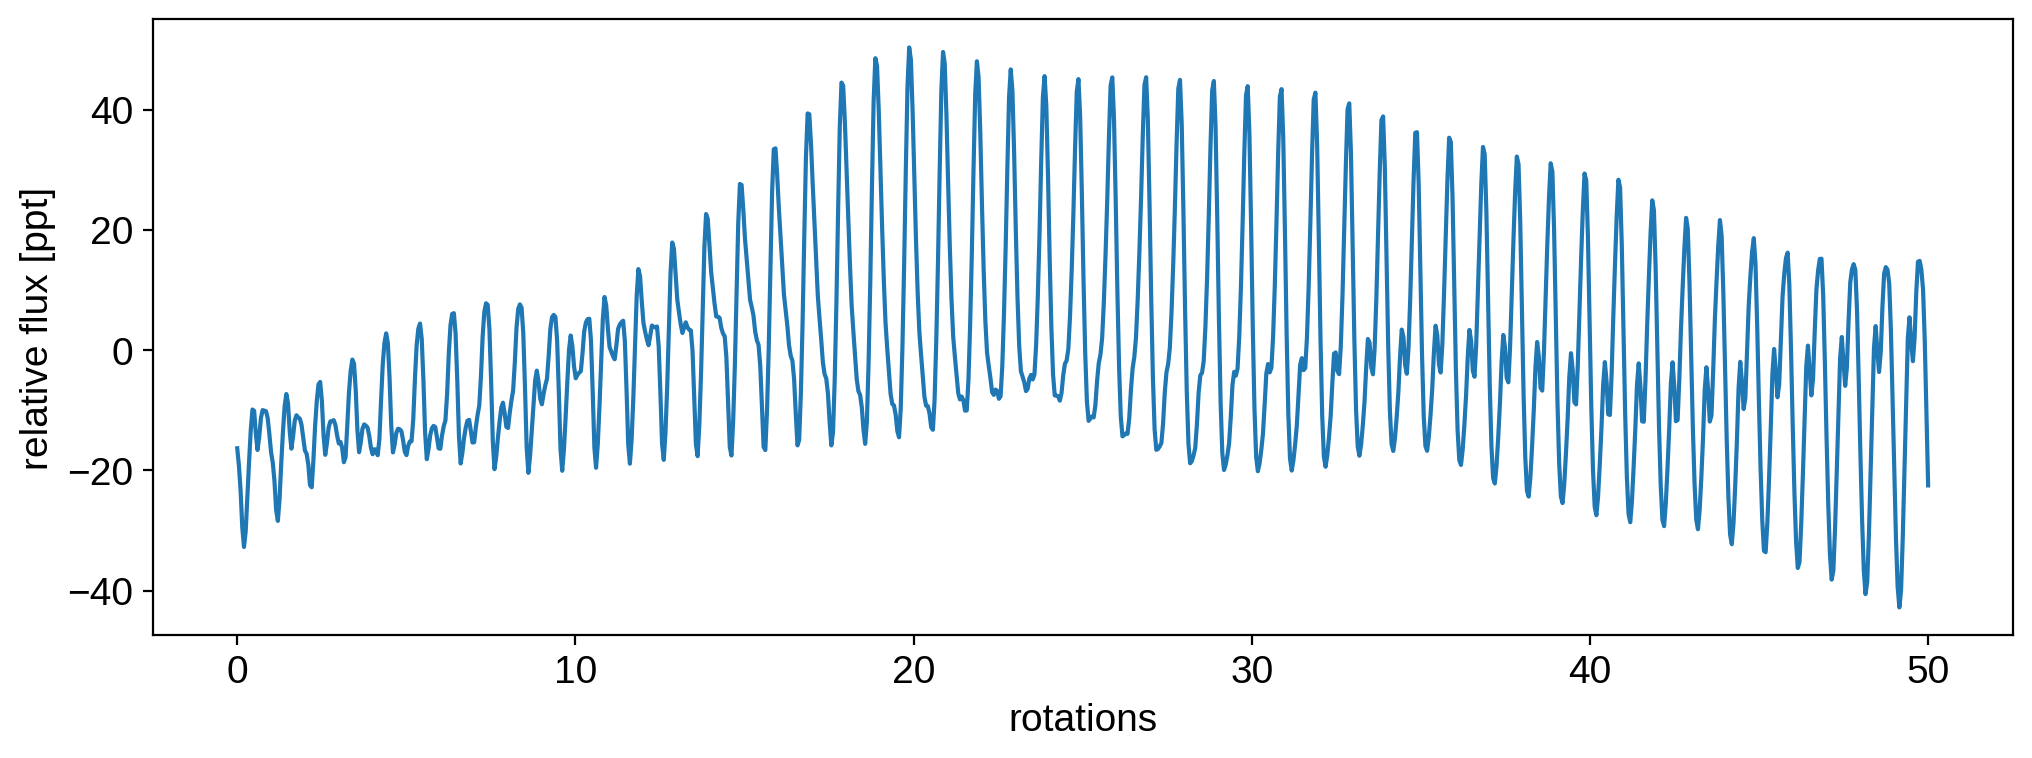

In [14]:
plt.plot(t, 1e3 * flux[0])
plt.xlabel("rotations")
plt.ylabel("relative flux [ppt]")
plt.show()

### Sampling in flux

We can also sample in flux directly:

In [15]:
flux = sp.sample(t, nsamples=50).eval()
flux

array([[ 0.07838618,  0.06464705,  0.04244707, ...,  0.06331804,
         0.05142009,  0.0365836 ],
       [ 0.01378447,  0.02370538,  0.03521725, ..., -0.04152575,
        -0.04475802, -0.04349481],
       [ 0.0590112 ,  0.06348585,  0.0546207 , ..., -0.02683003,
        -0.04158381, -0.04769547],
       ...,
       [-0.05463797, -0.07863731, -0.09790254, ...,  0.05184834,
         0.03765136,  0.01797497],
       [ 0.00605763,  0.0012725 , -0.00351335, ..., -0.04518317,
        -0.01887255,  0.00907892],
       [ 0.02490599,  0.0453551 ,  0.05680081, ...,  0.0147044 ,
         0.00834349,  0.0005404 ]])

where again it's useful to note the shape of the returned quantity, `(number of samples, number of time points)`:

In [16]:
flux.shape

(50, 1000)

Here are all 50 light curves plotted on the same scale:

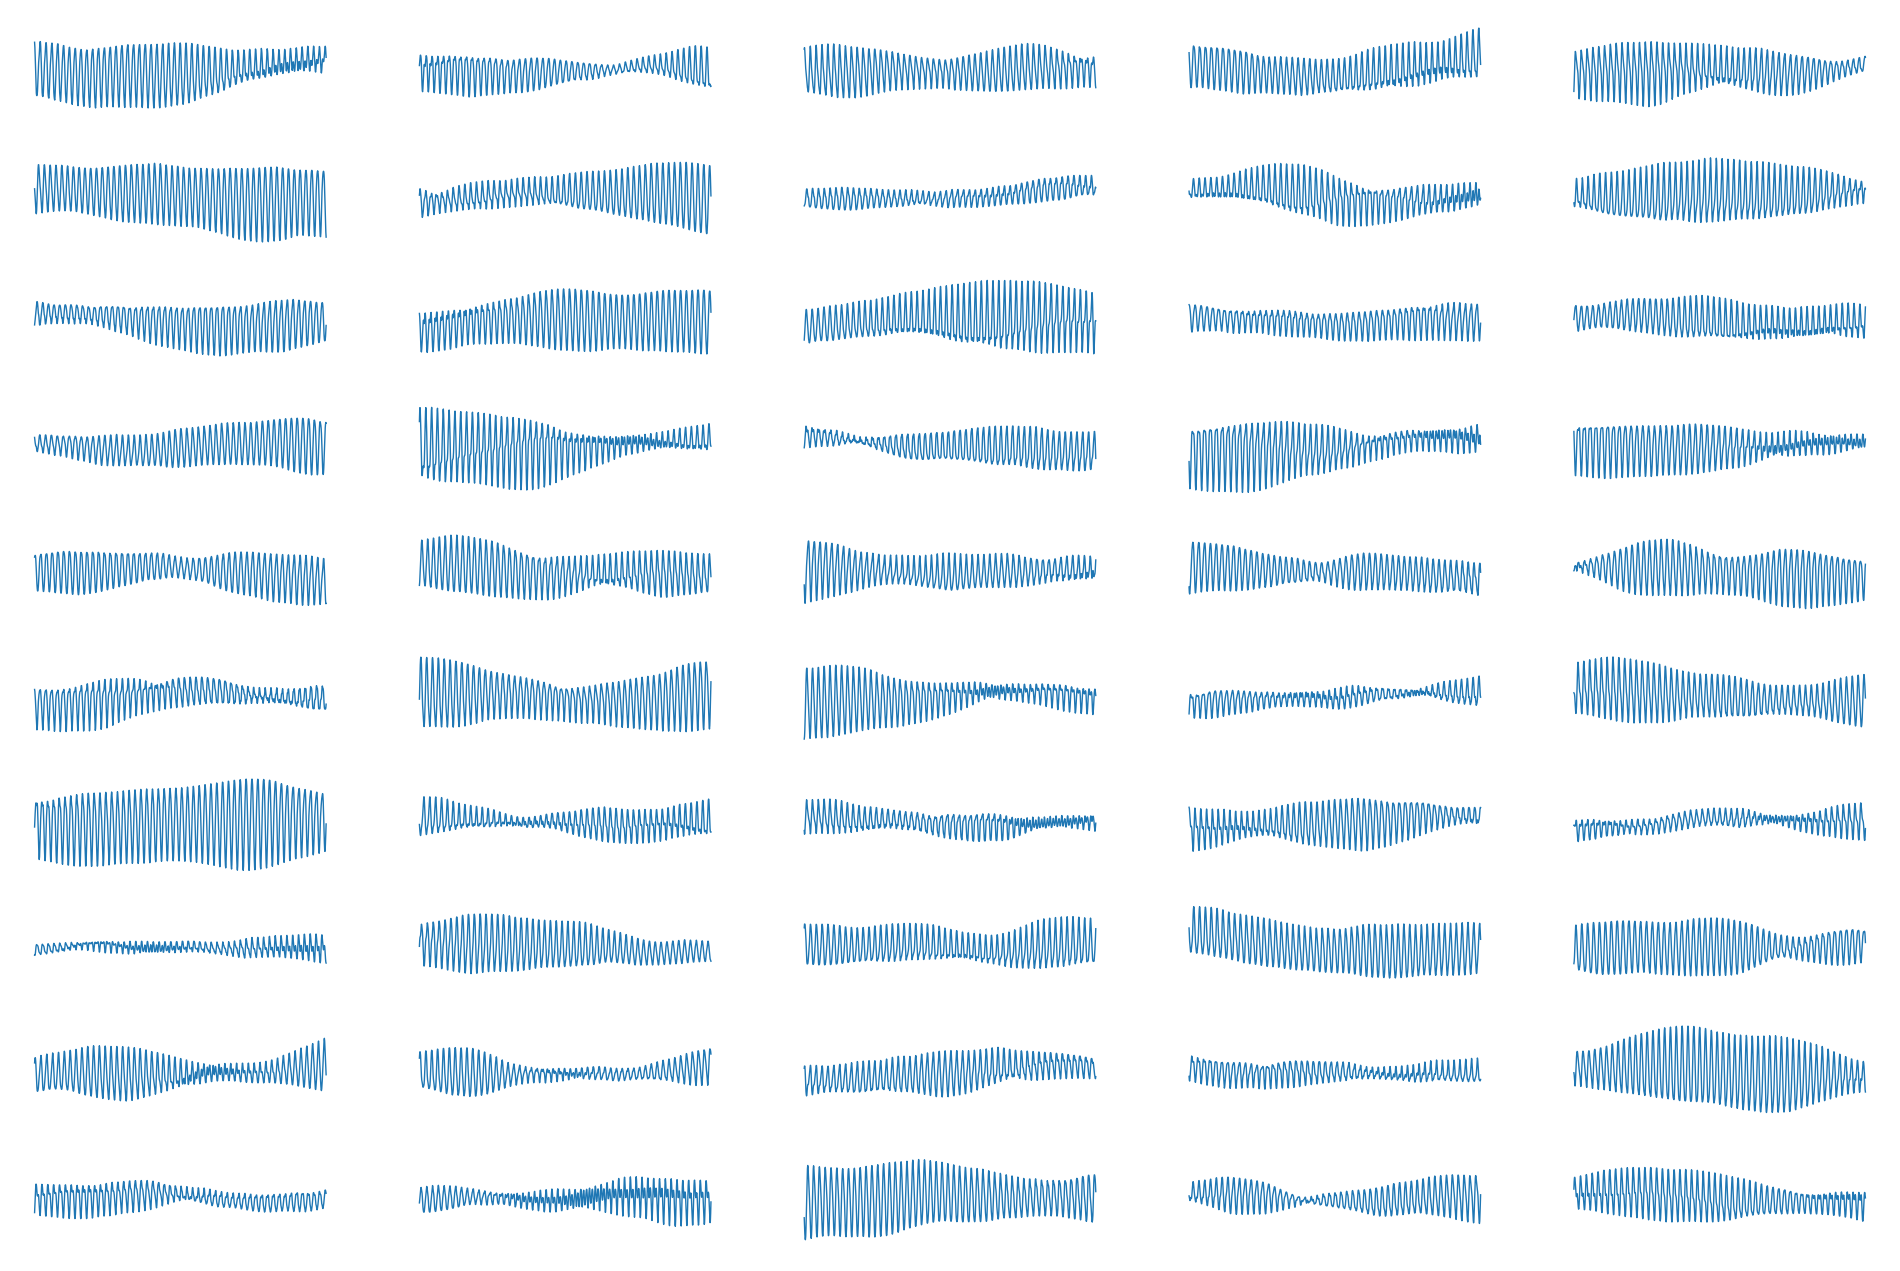

In [17]:
fig, ax = plt.subplots(10, 5, figsize=(12, 8), sharex=True, sharey=True)
ax = ax.flatten()
for k in range(50):
    ax[k].plot(t, 1e3 * flux[k], lw=0.5)
    ax[k].axis("off")

## Doing inference

We can also do inference using time-variable `StarryProcess` models. Let's do a mock ensemble analysis on the 50 light curves we generated above. First, let's add some observation noise. Here's what the first "observed" light curve looks like:

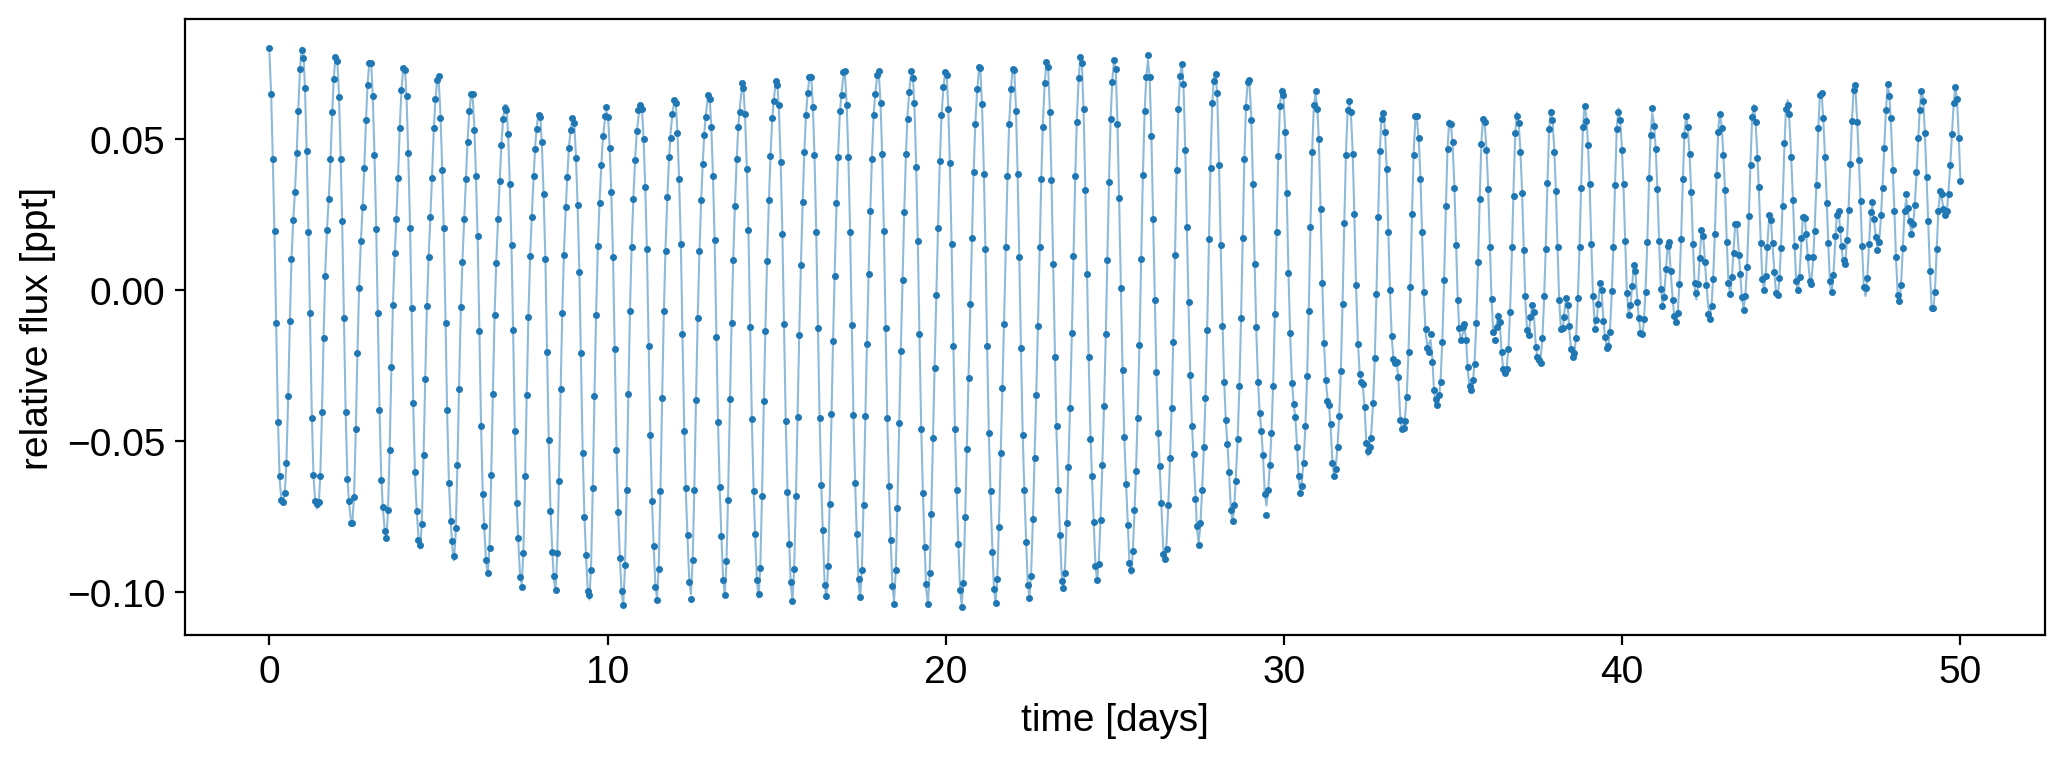

In [18]:
ferr = 1e-3
np.random.seed(0)
f = flux + ferr * np.random.randn(50, len(t))
plt.plot(t, flux[0], "C0-", lw=0.75, alpha=0.5)
plt.plot(t, f[0], "C0.", ms=3)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.show()

Now, let's try to infer the timescale of the generating process. For simplicity, we'll keep all other parameters fixed at their default (and in this case, true) values. As in the [Quickstart](Quickstart.ipynb) tutorial, we compile the likelihood function using `theano`. It will accept two inputs, a light curve and a timescale, and will return the corresponding log likelihood. To make this example run a little faster, we'll also downsample the light curves by a factor of 5 (not recommended in practice! We should never throw out information!)

In [19]:
f_tensor = tt.dvector()
tau_tensor = tt.dscalar()
log_likelihood = theano.function(
    [f_tensor, tau_tensor],
    StarryProcess(tau=tau_tensor).log_likelihood(t[::5], f_tensor[::5], ferr ** 2),
)

Compute the joint likelihood of all datasets:

In [20]:
tau = np.linspace(0, 50, 100)
ll = np.zeros_like(tau)
for k in tqdm(range(len(tau))):
    ll[k] = np.sum([log_likelihood(f[n], tau[k]) for n in range(50)])

  0%|          | 0/100 [00:00<?, ?it/s]

Following the same steps as in the [Quickstart](Quickstart.ipynb) tutorial, we can convert this into a posterior distribution by normalizing it (and implicitly assuming a uniform prior over `tau`):

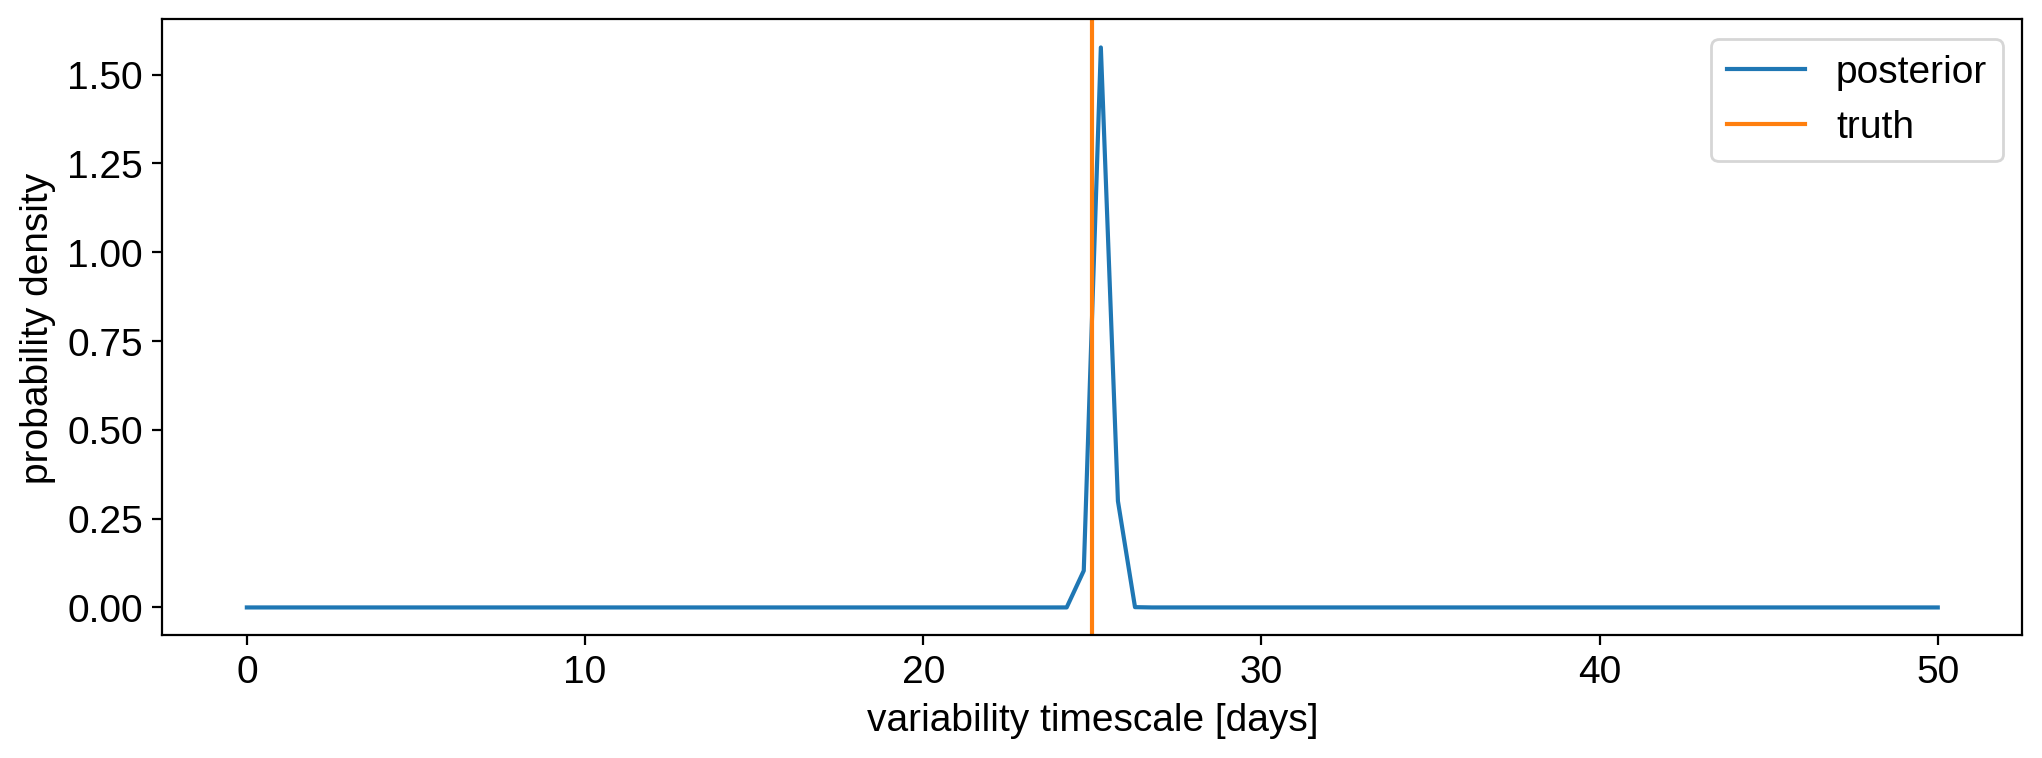

In [21]:
likelihood = np.exp(ll - np.max(ll))
prob = likelihood / np.trapz(likelihood, tau)
plt.plot(tau, prob, label="posterior")
plt.axvline(25, color="C1", label="truth")
plt.legend()
plt.ylabel("probability density")
plt.xlabel("variability timescale [days]")
plt.show()

As expected, we correctly infer the timescale of variability.